In [1]:
import csv
import os
import numpy as np
import h5py
import skimage.io
ck_path = 'CK+48'
from glob import glob
img_path_list = glob(ck_path+"\\*")
# Creat the list to store the data and label information
# train_pixel = []
# train_label = []
# test_pixel = []
# test_label = []
data_pixel = []
data_label = []
datapath = os.path.join('data','CK_data.npy')
if not os.path.exists(os.path.dirname(datapath)):
    os.makedirs(os.path.dirname(datapath))

In [2]:
import random
import torch

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(3407)

In [3]:
for i, img_path in enumerate(img_path_list):
    files = os.listdir(img_path)
    files.sort()
    length = len(files)
    for j, filename in enumerate(files):
        I = skimage.io.imread(os.path.join(img_path,filename))
        data_pixel.append(I.tolist())
        data_label.append(i)
        # if j<length*0.8:
        #     train_pixel.append(I.tolist())
        #     train_label.append(i)
        # else:
        #     test_pixel.append(I.tolist())
        #     test_label.append(i)

In [4]:
print(np.shape(data_label))
print(np.shape(data_pixel))

(981,)
(981, 48, 48)


In [5]:
# # Save data as numpy format
# np.save(datapath, [data_x, data_y])
# print("Save data finish!!!")

In [6]:
from PIL import Image
import numpy as np
import h5py
import torch.utils.data as data


class CK(data.Dataset):
    """`CK+ Dataset.

    Args:
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``

        there are 135,177,75,207,84,249,54 images in data
        we choose 123,159,66,186,75,225,48 images for training
        we choose 12,8,9,21,9,24,6 images for testing
        the split are in order according to the fold number
    """

    def __init__(self, data_pixel, data_label, fold=1, transform=None):
        self.transform = transform
        # self.split = split  # training set or test set
        self.fold = fold  # the k-fold cross validation
        # self.data = h5py.File('./data/CK_data.h5', 'r', driver='core')
        self.data_pixel = data_pixel
        self.data_label = data_label


    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = np.array(self.data_pixel[index]), self.data_label[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = img[:, :, np.newaxis]
        img = np.concatenate((img, img, img), axis=2)
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data_pixel)


In [7]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet18",
    "dataset": "CK+",
    "fold": 10,
    "bs": 128,
    "lr": 0.01,
    "resume": None,
}


best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

path = os.path.join(opt["dataset"] + '_' + opt["model"], str(opt["fold"]))

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])


==> Preparing data..


In [8]:
skf = StratifiedKFold(n_splits=opt["fold"])
for train_index, test_index in skf.split(data_pixel, data_label):
    # print(train_index, test_index)
    # for i in train_index:
    #     print(i)
    train_data, test_data = [data_pixel[i] for i in train_index], [data_pixel[i] for i in test_index]
    train_labels, test_labels = [data_label[i] for i in train_index], [data_label[i] for i in test_index]
trainset = CK(fold=opt["fold"], transform=transform_train, data_pixel=train_data, data_label=train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt["bs"], shuffle=True)
testset = CK(fold=opt["fold"], transform=transform_test, data_pixel=test_data, data_label=test_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)


In [9]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    print(inputs.shape)
    print(targets.shape)

torch.Size([128, 3, 44, 44])
torch.Size([128])
torch.Size([128, 3, 44, 44])
torch.Size([128])
torch.Size([128, 3, 44, 44])
torch.Size([128])
torch.Size([128, 3, 44, 44])
torch.Size([128])
torch.Size([128, 3, 44, 44])
torch.Size([128])
torch.Size([128, 3, 44, 44])
torch.Size([128])


D:\projects\Facial-Expression-Recognition\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


torch.Size([115, 3, 44, 44])
torch.Size([115])


In [10]:
from tqdm import tqdm

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = opt["lr"] * decay_factor
        utils.set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = opt["lr"]
    print('learning_rate: %s' % str(current_lr))

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # print(batch_idx, (inputs, targets))
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # print(inputs, targets)
        optimizer.zero_grad()
        # print(optimizer)
        inputs, targets = Variable(inputs), Variable(targets)
        # print(inputs, targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        utils.clip_gradient(optimizer, 0.1)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                           % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))



    Train_acc = 100. * correct / total



In [11]:
def test(epoch, all_predicted, all_targets):
    global Test_acc
    global best_Test_acc
    global best_Test_acc_epoch

    net.eval()
    PrivateTest_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops

        loss = criterion(outputs_avg, targets)
        PrivateTest_loss += loss.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        utils.progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                           % (PrivateTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        if batch_idx == 0:
            temp_all_predicted = predicted
            temp_all_targets = targets
        else:
            temp_all_predicted = torch.cat((temp_all_predicted, predicted), 0)
            temp_all_targets = torch.cat((temp_all_targets, targets), 0)

    # Save checkpoint.
    Test_acc = 100. * correct / total

    if Test_acc > best_Test_acc:
        print('Saving..')
        print("best_Test_acc: %0.3f" % Test_acc)
        state = {'net': net.state_dict() if use_cuda else net,
                 'best_Test_acc': Test_acc,
                 'best_Test_acc_epoch': epoch,
                 }
        if not os.path.isdir(opt["dataset"] + '_' + opt["model"]):
            os.mkdir(opt["dataset"] + '_' + opt["model"])
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path, 'resnet101_SEnet_Test_model.t7'))
        best_Test_acc = Test_acc
        best_Test_acc_epoch = epoch
        all_predicted = temp_all_predicted
        all_targets = temp_all_targets
        # print("test", all_predicted, all_targets)

    return all_predicted, all_targets


In [12]:
# Model
# if opt["model"] == 'VGG19':
#     net = VGG('VGG19')
# elif opt["model"] == 'ResNet18':
#     net = ResNet18()


# ResNet101

In [13]:
from models import resnet101
net = resnet101.resnet101(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)

==> Building model..


In [14]:
all_predicted = None
all_targets = None
for epoch in range(start_epoch, total_epoch):
    train(epoch)
    all_predicted, all_targets = test(epoch, all_predicted, all_targets)
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)


Epoch: 0
learning_rate: 0.01
 [=========== 7/7 


C:\Users\dragonplus\AppData\Local\Temp\ipykernel_16868\168344575.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


 [=========== 20/20 =====
Saving..
best_Test_acc: 18.367

Epoch: 1
learning_rate: 0.01
 [=========== 7/7 
======>....] | Loss: 2.193 | Acc: 5.556% [=========== 19/20 =========== 20/20 

Epoch: 2
learning_rate: 0.01
 [=========== 7/7 
 [=========== 15/20 =========== 16/20 =========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 3
learning_rate: 0.01
 [=========== 7/7 
 [=========== 20/20 
Saving..
best_Test_acc: 56.122

Epoch: 4
learning_rate: 0.01
 [=========== 7/7 
 [=========== 15/20 =========== 16/20 =========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 5
learning_rate: 0.01
 [=========== 7/7 
 [=========== 20/20 
Saving..
best_Test_acc: 60.204

Epoch: 6
learning_rate: 0.01
 [=========== 7/7 
 [=========== 16/20 =========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 7
learning_rate: 0.01
 [=========== 7/7 
 [=========== 20/20 
Saving..
best_Test_acc: 73.469

Epoch: 8
learning_rate: 0.01
 [=========== 7/7 
 

In [15]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.46 0.   0.23 0.   0.   0.31 0.  ]
 [0.   0.4  0.6  0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.12 0.   0.88 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.96]]


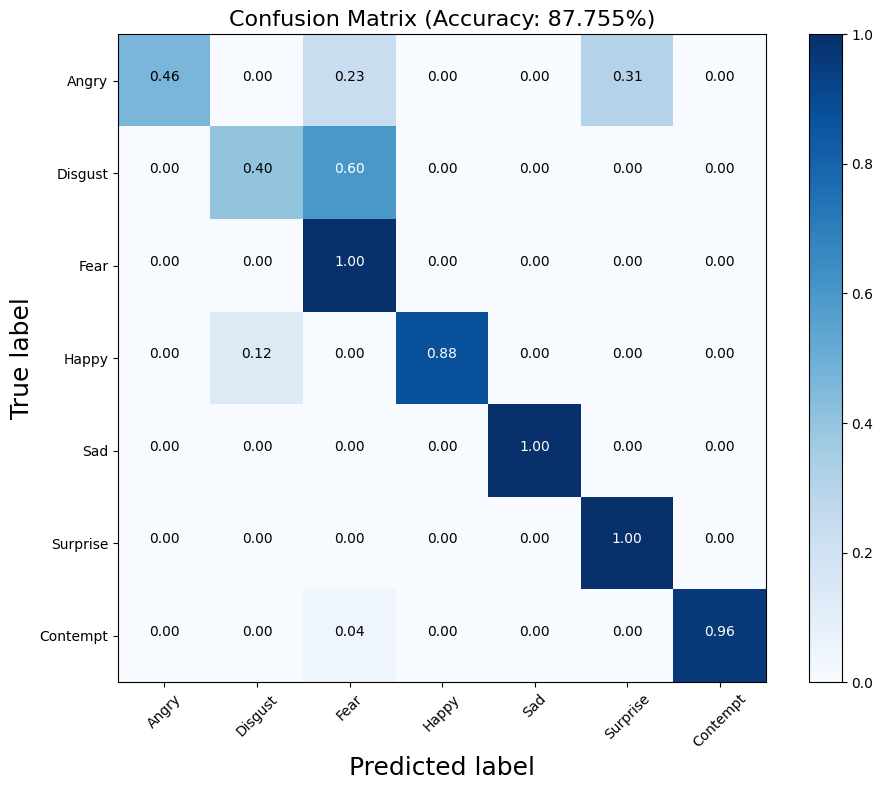

In [16]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'Confusion Matrix.png'))
plt.close()

# Resnet101 + SE Attention

In [12]:
from models import resnet101_SEAttention
net = resnet101_SEAttention.resnet101_SE_attention(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)



==> Building model..


In [13]:
all_predicted = None
all_targets = None
for epoch in range(start_epoch, total_epoch):
    train(epoch)
    all_predicted, all_targets = test(epoch, all_predicted, all_targets)
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)



Epoch: 0
learning_rate: 0.01


D:\projects\Facial-Expression-Recognition\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


 [=========== 7/7 


C:\Users\dragonplus\AppData\Local\Temp\ipykernel_16688\168344575.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


=====>.. [=========== 18/20 =========== 19/20 =========== 20/20 
Saving..
best_Test_acc: 13.265

Epoch: 1
learning_rate: 0.01
 [=========== 7/7 
==>........] | Loss: 2.052 | Acc: 6.667% (5/75)         [=========== 16/20 =========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 2
learning_rate: 0.01
 [=========== 7/7 
 [=========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 3
learning_rate: 0.01
 [=========== 7/7 
 [=========== 19/20 =========== 20/20 

Epoch: 4
learning_rate: 0.01
 [=========== 7/7 
 [=========== 18/20 =========== 19/20 =========== 20/20 
Saving..
best_Test_acc: 39.796

Epoch: 5
learning_rate: 0.01
 [=========== 7/7 
 [=========== 20/20 
Saving..
best_Test_acc: 62.245

Epoch: 6
learning_rate: 0.01
 [=========== 7/7 
>..........] | Loss: [=========== 15/20 =========== 16/20 =========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 
Saving..
best_Test_acc: 64.286

Epoch: 7
learning_rate: 0.01
 [=========== 5/

In [12]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.62 0.08 0.   0.   0.   0.31 0.  ]
 [0.   0.4  0.   0.   0.   0.   0.6 ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.33 0.   0.   0.   0.67 0.  ]
 [0.   0.   0.   0.   0.   0.04 0.96]]


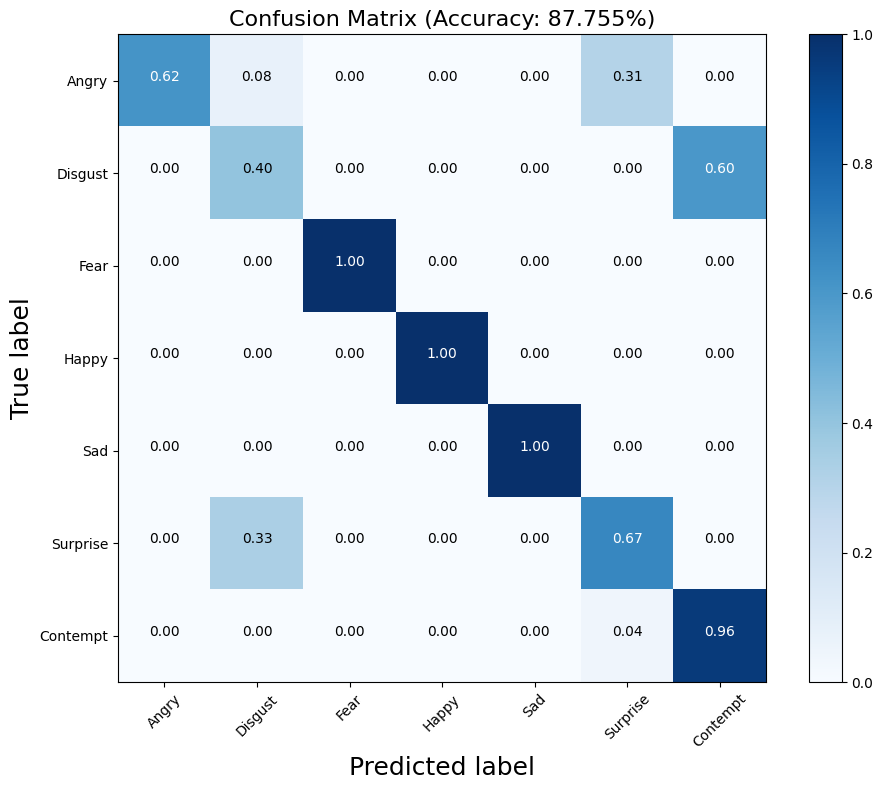

In [16]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'Confusion Matrix.png'))
plt.close()

# 自注意力机制(transformer encode部分)

In [13]:
from models import resnet101_SelfAttention

net = resnet101_SelfAttention.resnet101_self_attention(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)


==> Building model..


In [14]:
all_predicted = None
all_targets = None
for epoch in range(start_epoch, total_epoch):
    train(epoch)
    all_predicted, all_targets = test(epoch, all_predicted, all_targets)
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)


Epoch: 0
learning_rate: 0.01


D:\projects\Facial-Expression-Recognition\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


 [=========== 7/7 


C:\Users\dragonplus\AppData\Local\Temp\ipykernel_16560\168344575.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


 [=========== 20/20 
Saving..
best_Test_acc: 20.408

Epoch: 1
learning_rate: 0.01
 [=========== 7/7 
=====>.....] | Loss: 2.069 | Acc: 5.882% (5/85)            === 12/20 ===== [=========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 2
learning_rate: 0.01
 [=========== 7/7 
 [=========== 20/20 

Epoch: 3
learning_rate: 0.01
 [=========== 7/7 
========>..] | Loss: 2.150 | Acc: 17.895% (1 [=========== 20/20 

Epoch: 4
learning_rate: 0.01
 [=========== 7/7 
======>....] | Loss: 1.766 | Acc: 30.000% ( [=========== 19/20 =========== 20/20 
Saving..
best_Test_acc: 35.714

Epoch: 5
learning_rate: 0.01
 [=========== 7/7 
 [=========== 14/20 =========== 15/20 =========== 16/20 =========== 17/20 =========== 18/20 =========== 19/20 =========== 20/20 
Saving..
best_Test_acc: 68.367

Epoch: 6
learning_rate: 0.01
 [=========== 7/7 
 [=========== 18/20 =========== 19/20 =========== 20/20 

Epoch: 7
learning_rate: 0.01
 [=========== 7/7 
 [=========== 18/20 =========== 19/20 =========== 20/20 
S

Normalized confusion matrix
[[0.54 0.   0.38 0.   0.   0.08 0.  ]
 [0.   0.4  0.   0.6  0.   0.   0.  ]
 [0.   0.   0.94 0.06 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.33 0.   0.   0.   0.67 0.  ]
 [0.   0.   0.   0.04 0.   0.   0.96]]


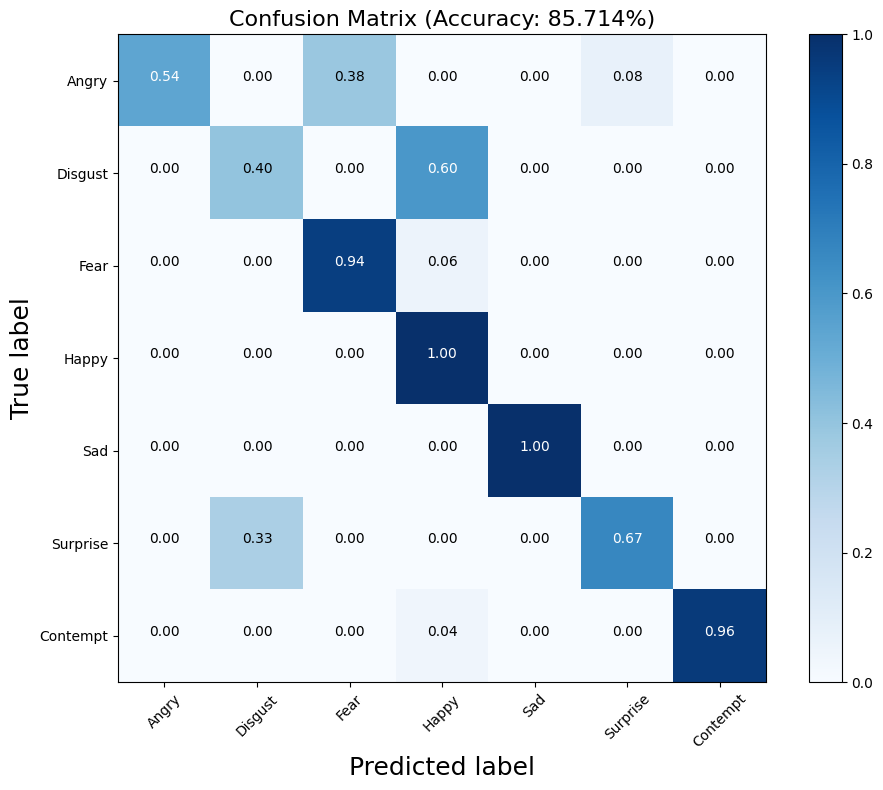

In [15]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'Confusion Matrix.png'))
plt.close()